In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
from typing import Literal
from scipy.stats import levene, mannwhitneyu
from matplotlib import pyplot as plt
from ucimlrepo import fetch_ucirepo

# Introduction
We saw during exploratory data analysis that the numerical variables in this dataset are not normally distributed. We will statistical tests that work without the normality assumption.

In [55]:
studentData = fetch_ucirepo(id=320)

X = studentData.data.features
y = studentData.data.targets

fullData = pd.concat([X, y], axis=1)
fullData

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,5,4,2,1,2,5,4,10,11,10
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,4,15,15,16
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,1,5,6,11,12,9
647,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,6,10,10,10


# Useful Functions

In [56]:
def plotKDE(legend, *groups):
	"""
	Plot the KDE of the given groups
	"""
	if legend == None or len(legend) != len(groups):
		legend = ['Group '+str(i) for i in range(len(groups))]
		print('Legend not provided or not matching the number of groups. Using default legend.')
	for index, (group, label) in enumerate(zip(groups, legend)):
		sns.kdeplot(group, label=label, color='C'+str(index))
	plt.legend()
	plt.show()

def leveneTest(group1, group2):
	"""
	Perform the Levene test for homogeneity of variance.
	"""
	statistic, pvalue = levene(group1, group2)
	print('Levene Test for Homogeneity of Variance')
	print('Statistic:\t', statistic)
	print('P-Value:\t', pvalue)
	if pvalue < 0.05:
		print('Reject Null Hypothesis: Variances are not equal')
	else:
		print('Fail to Reject Null Hypothesis: Variances are equal')

def mannWhitneyU(group1, group2, alternative : Literal['two-sided', 'less', 'greater'] = 'two-sided'):
	"""
	Perform the Mann-Whitney U test.
	"""
	statistic, pvalue = mannwhitneyu(group1, group2, alternative=alternative)
	effectSize = 1 - 2 * (statistic / (len(group1) * len(group2)))
	print('Mann-Whitney U Test for Independent Samples')
	print('Statistic:\t', statistic)
	print('P-Value:\t', pvalue)
	stmts = {
		'two-sided': 'The two samples are not equal.',
		'less': 'The first sample is less than the second sample.',
		'greater': 'The first sample is greater than the second sample.'
	}
	if pvalue < 0.05:
		print('Reject Null Hypothesis:', stmts[alternative])
	else:
		print('Fail to Reject Null Hypothesis. There is no significant difference between the two samples.')

# Hypothesis Testing
In this notebook, we will formulate several hypotheses about the data and evaluate them using statistical tests.
## 1 Urban students have better scores (G3) than rural students.
**Null Hypothesis ($H_0$)**: There is no difference in the scores (G3) of urban and rural students.
**Alternate Hypothesis ($H_A$)**: Urban students have higher scores (G3) than rural students (Directional Hypothesis).

Let us divide the data into 2 groups and visualize the distribution of math scores for each group.

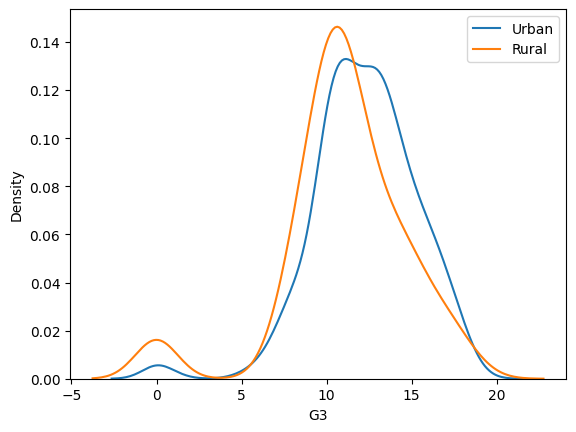

In [57]:
urbanGroup, ruralGroup = fullData[fullData['address'] == 'U'], fullData[fullData['address'] == 'R']
plotKDE(['Urban', 'Rural'], urbanGroup['G3'], ruralGroup['G3'])

Let us test whether the different groups have equal variance using Levene's test.

In [58]:
leveneTest(urbanGroup['G3'], ruralGroup['G3'])

Levene Test for Homogeneity of Variance
Statistic:	 0.7239882719673109
P-Value:	 0.3951535774387681
Fail to Reject Null Hypothesis: Variances are equal


Since the variances are equal and the data is not normally distributed, we will use the Mann-Whitney U test to test the hypothesis.
- In order to preserve independence, i.e. each student is independent of each other, we will assume that the performance of one student does not affect the performance of another student. We will later relax this assumption and use other statistical tests.

In [59]:
mannWhitneyU(urbanGroup['G3'], ruralGroup['G3'], alternative='two-sided')

Mann-Whitney U Test for Independent Samples
Statistic:	 53947.0
P-Value:	 1.567380447966654e-05
Reject Null Hypothesis: The two samples are not equal.


Now that we have confirmed that there is a significant difference between the two groups, let us test the directional hypothesis by specifying the alternative keyword as 'greater'. This will test whether the grade distribution of Urban students is greater than that of Rural students.

In [60]:
mannWhitneyU(urbanGroup['G3'], ruralGroup['G3'], alternative='greater')

Mann-Whitney U Test for Independent Samples
Statistic:	 53947.0
P-Value:	 7.83690223983327e-06
Reject Null Hypothesis: The first sample is greater than the second sample.


By the Mann-Whitney U test, we can conclude that Urban students have higher scores (G3) than Rural students.

One interesting thing to note here is that 2 different school may have different grading policies and liniency. Let us test whether different schools have a difference in the scores (G3) of students.

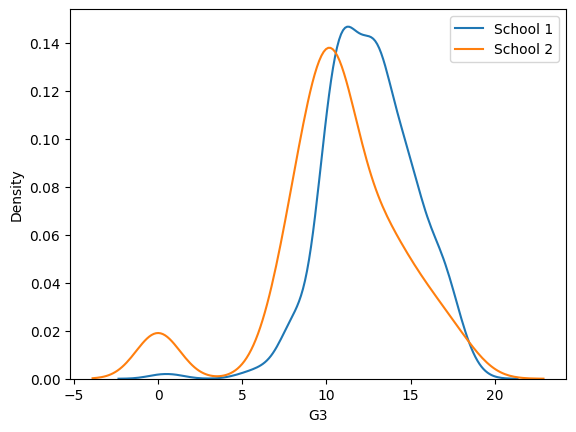

Levene Test for Homogeneity of Variance
Statistic:	 0.7239882719673109
P-Value:	 0.3951535774387681
Fail to Reject Null Hypothesis: Variances are equal


In [70]:
school1 = fullData[fullData['school'] == 'GP']
school2 = fullData[fullData['school'] == 'MS']

plotKDE(['School 1', 'School 2'], school1['G3'], school2['G3'])
leveneTest(urbanGroup['G3'], ruralGroup['G3'])

In [69]:
mannWhitneyU(school1['G3'], school2['G3'], alternative='two-sided')
mannWhitneyU(school1['G3'], school2['G3'], alternative='greater')
mannWhitneyU(school1['G3'], school2['G3'], alternative='less')

Mann-Whitney U Test for Independent Samples
Statistic:	 64220.5
P-Value:	 3.7923848332712816e-13
Reject Null Hypothesis: The two samples are not equal.
Mann-Whitney U Test for Independent Samples
Statistic:	 64220.5
P-Value:	 1.8961924166356408e-13
Reject Null Hypothesis: The first sample is greater than the second sample.
Mann-Whitney U Test for Independent Samples
Statistic:	 64220.5
P-Value:	 0.999999999999811
Fail to Reject Null Hypothesis. There is no significant difference between the two samples.


As we can see, school 2 tends to give a higher grade to its students. Let us test for each school whether there is a difference in the scores (G3) of students between Urban and Rural areas.

### School 1 : MS

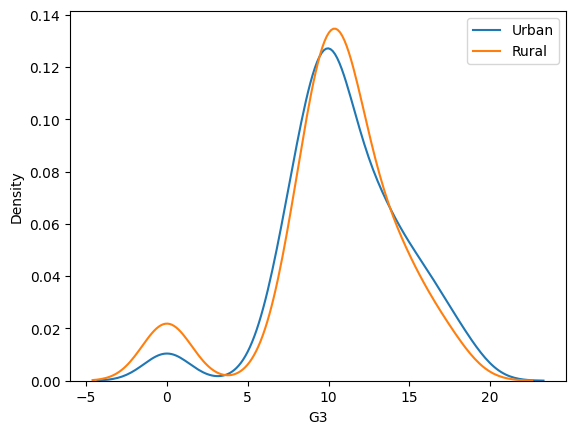

Levene Test for Homogeneity of Variance
Statistic:	 0.0018320452028901177
P-Value:	 0.9658971818860357
Fail to Reject Null Hypothesis: Variances are equal


In [78]:
urbanGroup1, ruralGroup1 = fullData[(fullData['address'] == 'U') & (fullData['school'] == 'MS')], fullData[(fullData['address'] == 'R') & (fullData['school'] == 'MS')]
plotKDE(['Urban', 'Rural'], urbanGroup1['G3'], ruralGroup1['G3'])

leveneTest(urbanGroup1['G3'], ruralGroup1['G3'])

In [79]:
mannWhitneyU(urbanGroup1['G3'], ruralGroup1['G3'], alternative='two-sided')

Mann-Whitney U Test for Independent Samples
Statistic:	 6506.0
P-Value:	 0.7754134086866773
Fail to Reject Null Hypothesis. There is no significant difference between the two samples.


As we can see, there is no significant difference in the scores (G3) of students between Urban and Rural areas for school 1.

### School 2 : GP

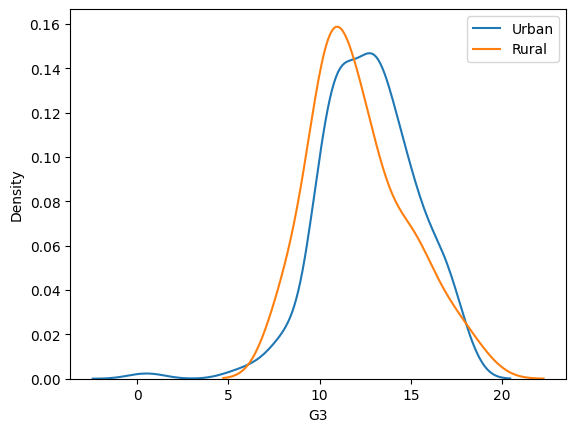

Levene Test for Homogeneity of Variance
Statistic:	 0.028076337829687024
P-Value:	 0.867009935804166
Fail to Reject Null Hypothesis: Variances are equal


In [80]:
urbanGroup2, ruralGroup2 = fullData[(fullData['address'] == 'U') & (fullData['school'] == 'GP')], fullData[(fullData['address'] == 'R') & (fullData['school'] == 'GP')]
plotKDE(['Urban', 'Rural'], urbanGroup2['G3'], ruralGroup2['G3'])

leveneTest(urbanGroup2['G3'], ruralGroup2['G3'])

In [81]:
mannWhitneyU(urbanGroup2['G3'], ruralGroup2['G3'], alternative='two-sided')

Mann-Whitney U Test for Independent Samples
Statistic:	 15632.5
P-Value:	 0.024456465556027766
Reject Null Hypothesis: The two samples are not equal.


As we can see, there is a significant difference in the scores (G3) of students between Urban and Rural areas for school 2. Let us test the directional hypothesis as done above.

In [82]:
mannWhitneyU(urbanGroup2['G3'], ruralGroup2['G3'], alternative='greater')

Mann-Whitney U Test for Independent Samples
Statistic:	 15632.5
P-Value:	 0.012228232778013883
Reject Null Hypothesis: The first sample is greater than the second sample.


For school 2 : GP, we conclude that urban students have higher scores (G3) than rural students.

This means that rural students in school 2 tend to have lower scores than urban students. This could indicate 